# TP3 : Attention



In [40]:
import math
import torch

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

# Attention

In [159]:
# Input size : b, T, dk
# Output size : b, T, dv
class SelfAttentionCustom(nn.Module):
    def __init__(self, dk=10, dv=10):
        super().__init__()
        self.dk = dk
        self.dv = dv

        # Define the linear layers to project input to keys, queries, and values
        self.to_keys = nn.Linear(self.dk, self.dk, bias=False)
        self.to_queries = nn.Linear(self.dk, self.dk, bias=False)
        self.to_values = nn.Linear(self.dk, self.dv, bias=False)

    def forward(self, xs):
        K = self.to_keys(xs)  # b, T,  dk
        Q = self.to_queries(xs)  # b, T,  dk

        attention_scores = Q @ K.transpose(-1, -2) / math.sqrt(self.dk)  # b, T,  N
        attention_weights = torch.softmax(attention_scores, dim=-1)  # b, T,  N

        V = self.to_values(xs)  # b, T,  dv

        out = attention_weights @ V  # b, T, dv

        return out

In [ ]:
attention_custom = SelfAttention(dk=10, dv=10)

x = torch.randn(5, 3, 10)  # b, T, k
print(attention_custom(x))

tensor([[[ 1.3055e-01, -5.7348e-01,  3.8210e-01,  3.1962e-01,  2.4773e-02,
           3.7901e-01, -1.8147e-01, -1.4613e-01,  5.2368e-03,  9.0831e-02],
         [ 6.9584e-02, -5.9429e-01,  3.0584e-01,  3.7671e-01,  4.5792e-02,
           3.9371e-01, -1.8061e-01, -6.0471e-02,  5.4929e-02,  4.9849e-02],
         [ 8.2619e-02, -5.7171e-01,  3.1698e-01,  3.7129e-01,  3.8222e-02,
           3.7362e-01, -1.7469e-01, -7.4930e-02,  3.5808e-02,  5.2091e-02]],

        [[ 7.9671e-01,  1.4645e-01,  2.9617e-01,  3.2808e-01,  1.7469e-01,
          -4.6918e-02, -5.1045e-01,  2.8036e-01,  4.0185e-02, -1.8865e-01],
         [ 5.7907e-01,  2.0074e-01,  4.0883e-01,  2.2336e-01,  1.4136e-01,
          -1.3774e-01, -4.2486e-01,  2.7121e-01,  5.2377e-04, -2.6384e-01],
         [ 9.5375e-01,  1.1538e-01,  2.2517e-01,  3.9333e-01,  2.0039e-01,
           1.0931e-02, -5.7040e-01,  2.8475e-01,  6.2594e-02, -1.3500e-01]],

        [[-3.9389e-01, -1.3259e-02,  5.7662e-01, -1.9421e-01,  4.0133e-01,
           3.45

# Multi-head Attention

### Start naive with a for loop

Use torch.cat to concatenate together a list of tensors on a given dimension.

In [179]:
class MultiHeadAttentionCustom(nn.Module):
    def __init__(self, h=5, dk=10, dv=10):
        super().__init__()
        self.dk = dk
        self.dv = dv
        self.h = h

        self.to_keys = nn.Linear(dk, dk, bias=False)
        self.to_queries = nn.Linear(dk, dk, bias=False)
        self.to_values = nn.Linear(dk, dv, bias=False)

        self.unifyhead = nn.Linear(dv, dv)

    def forward(self, x):
        h, dk, dv = self.h, self.dk, self.dv
        dkh, dvh = dk // h, dv // h  # dimension per head

        K = self.to_keys(x)  # b, T, dk
        Q = self.to_queries(x)
        V = self.to_values(x)

        head_outputs = []
        for i in range(h):
            k_start, k_end = i * dkh, (i + 1) * dkh
            v_start, v_end = i * dvh, (i + 1) * dvh

            Ki = K[:, :, k_start:k_end]  # b, T, dkh
            Qi = Q[:, :, k_start:k_end]  # b, T, dkh
            Vi = V[:, :, v_start:v_end]  # b, T, dvh

            scores = (Qi @ Ki.transpose(-2, -1)) / math.sqrt(dkh)  # b, T, T
            Ai = torch.softmax(scores, dim=-1)
            head_outputs.append(Ai @ Vi)  # b, T, dvh

        # concatenate along feature dimension
        out = torch.cat(head_outputs, dim=-1)  # b, T, dv
        return self.unifyhead(out)


x = torch.randn(2, 10, 32)  # b, T, k
block = MultiHeadAttentionCustom(h=4, dk=32, dv=16)
out = block(x)
print(out.shape)

torch.Size([2, 10, 16])


### Vectorized

To change the shape of a tensor, use the view or reshape function. 
For example:

In [180]:
x = torch.randn(2, 4)  # b, T, k
print(x)
x = x.view(2, 2, 2)
print(x)

tensor([[-0.8621, -0.5491,  0.1811, -0.1427],
        [-0.4041,  0.2707,  1.1505,  0.1863]])
tensor([[[-0.8621, -0.5491],
         [ 0.1811, -0.1427]],

        [[-0.4041,  0.2707],
         [ 1.1505,  0.1863]]])


In [ ]:
# Input size : b, T, dk
# Output size : b, T, dv
class MultiHeadAttentionVectorized(nn.Module):
    def __init__(self, h=5, dk=10, dv=10):
        super().__init__()
        self.d_k = dk
        self.dv = dv
        self.h = h

        self.to_keys = nn.Linear(dk, dk, bias=False)
        self.to_queries = nn.Linear(dk, dk, bias=False)
        self.to_values = nn.Linear(dk, dv, bias=False)

        self.unifyhead = nn.Linear(dv, dv)

    def forward(self, x):
        # Input size : b, T, dk
        # Output size : b, T, dv

        b, T, dk = x.shape
        h, dv = self.h, self.dv

        # Get queries, keys, values
        Q = self.to_queries(x)  # (b, T, dk)
        K = self.to_keys(x)
        V = self.to_values(x)

        # split into heads
        Q = Q.view(b, T, h, dk // h).transpose(1, 2)  # (b, h, T, d_head)
        K = K.view(b, T, h, dk // h).transpose(1, 2)
        V = V.view(b, T, h, dv // h).transpose(1, 2)  # (b, h, T, dv/h)

        # scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (math.sqrt((dk // h)))
        # (b, h, T, T)
        attn = F.softmax(scores, dim=-1)
        out = torch.matmul(attn, V)  # (b, h, T, dv/h)

        # concat heads
        out = out.transpose(1, 2).contiguous().view(b, T, dv)  # (b, T, dv)

        # unify heads
        return self.unifyhead(out)

In [182]:
x = torch.randn(2, 10, 32)  # b, T, k
MHAVect = MultiHeadAttentionVectorized(h=4, dk=32, dv=16)
MHACustom = MultiHeadAttentionCustom(h=4, dk=32, dv=16)

# Since both models have the same architecture, we can copy the weights
MHAVect.load_state_dict(MHACustom.state_dict())

out_vect = MHAVect(x)
out_custom = MHACustom(x)
print(out_vect - out_custom)  # should be all zeros


tensor([[[ 0.0000e+00, -2.9802e-08,  1.4901e-08,  0.0000e+00,  0.0000e+00,
          -1.4901e-08,  0.0000e+00,  0.0000e+00,  1.8626e-08, -7.4506e-09,
          -2.9802e-08,  1.4901e-08,  0.0000e+00,  1.4901e-08, -1.4901e-08,
           1.1176e-08],
         [ 1.4901e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          -1.4901e-08, -1.4901e-08,  0.0000e+00,  0.0000e+00,  7.4506e-09,
           0.0000e+00],
         [ 1.4901e-08, -2.9802e-08,  0.0000e+00,  0.0000e+00,  1.4901e-08,
           0.0000e+00,  1.4901e-08,  0.0000e+00, -1.4901e-08,  0.0000e+00,
          -1.4901e-08,  0.0000e+00,  2.2352e-08,  0.0000e+00,  0.0000e+00,
          -1.1176e-08],
         [-1.4901e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00, -1.4901e-08, -1.4901e-08,  7.4506e-09,
           0.0000e+00,  1.4901e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          -7.4506e-09],
    

In [132]:
%timeit MHACustom(x)
%timeit MHAVect(x)

326 μs ± 5.04 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
119 μs ± 335 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Faster
We can even use torch.bmm for faster implementation. 

torch.bmm is highly optimized matrix multiplication specifically 
for inputs of shape (b, n, m), (b, m, k) 

In [183]:
# Input size : b, T, dk
# Output size : b, T, dv
class MultiHeadAttentionBMM(nn.Module):
    def __init__(self, h=5, dk=10, dv=10):
        super().__init__()
        self.dk = dk
        self.dv = dv
        self.h = h

        self.to_keys = nn.Linear(dk, dk, bias=False)
        self.to_queries = nn.Linear(dk, dk, bias=False)
        self.to_values = nn.Linear(dk, dv, bias=False)

        self.unifyhead = nn.Linear(dv, dv)

    def forward(self, x):
        # Input:  (b, T, dk)
        # Output: (b, T, dv)
        b, T, dk = x.shape
        h, dv = self.h, self.dv
        dh = dk // h

        # project
        Q = self.to_queries(x).view(b, T, h, dh).transpose(1, 2)  # b, h, T, dh
        K = self.to_keys(x).view(b, T, h, dh).transpose(1, 2)  # b, h, T, dh
        V = self.to_values(x).view(b, T, h, dv // h).transpose(1, 2)  # b, h, T, dv // h

        # reshape for bmm: merge batch and head dims
        Q = Q.reshape(b * h, T, dh)
        K = K.reshape(b * h, T, dh)
        V = V.reshape(b * h, T, dv // h)

        # scaled dot-product attention
        scores = torch.bmm(Q, K.transpose(1, 2)) / math.sqrt(dh)  # (b*h, T, T)
        attn = torch.softmax(scores, dim=-1)
        out = torch.bmm(attn, V)  # (b*h, T, dv)

        # reshape back and unify heads
        out = out.view(b, h, T, dv // h).transpose(1, 2).reshape(b, T, dv)
        return self.unifyhead(out)

In [184]:
x = torch.randn(32, 10, 32)  # b, T, k
MHACustom = MultiHeadAttentionCustom(h=4, dk=32, dv=16)
MHAVect = MultiHeadAttentionVectorized(h=4, dk=32, dv=16)
MHABmm = MultiHeadAttentionBMM(h=4, dk=32, dv=16)

# Since both models have the same architecture, we can copy the weights
MHAVect.load_state_dict(MHACustom.state_dict())
MHABmm.load_state_dict(MHACustom.state_dict())

out_custom = MHACustom(x)
out_vect = MHAVect(x)
out_BMM = MHABmm(x)
# print(out_vect - out_custom)  # should be all zeros
print(out_vect - out_BMM)  # should be all zeros

tensor([[[ 1.4901e-08, -1.4901e-08,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.4901e-08,  ...,  0.0000e+00,
          -1.4901e-08,  1.4901e-08],
         [ 1.4901e-08,  1.4901e-08,  0.0000e+00,  ..., -2.9802e-08,
           1.4901e-08, -1.4901e-08],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.4901e-08,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -1.4901e-08, -1.4901e-08,  ...,  0.0000e+00,
           0.0000e+00,  1.4901e-08],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  2.9802e-08]],

        [[ 0.0000e+00, -1.4901e-08,  0.0000e+00,  ...,  0.0000e+00,
           7.4506e-09, -7.4506e-09],
         [ 2.9802e-08,  0.0000e+00,  2.2352e-08,  ..., -1.4901e-08,
           0.0000e+00, -2.9802e-08],
         [ 0.0000e+00, -1.4901e-08, -7.4506e-09,  ...,  0.0000e+00,
           0.0000e+00,  1.4901e-08],
         ...,
         [ 0.0000e+00,  0

In [185]:
%timeit MHACustom(x)
%timeit MHAVect(x)
%timeit MHABmm(x)

924 μs ± 23.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
691 μs ± 19.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
669 μs ± 21.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Add Masking

Apply causal masking to prevent tokens from attending future tokens.

Use the torch.tril (or torch.triu) function to build a triangular mask that will be applied to to the attention scores (see lecture slides).

Use the 'masked_fill' function to apply the mask to the attention scores matrix. 

In [ ]:
class MultiHeadAttentionCausal(nn.Module):
    def __init__(self, h=5, dk=10, dv=10):
        super().__init__()
        self.d_k = dk
        self.dv = dv
        self.h = h

        self.to_keys = nn.Linear(dk, dk, bias=False)
        self.to_queries = nn.Linear(dk, dk, bias=False)
        self.to_values = nn.Linear(dk, dv, bias=False)

        self.unifyhead = nn.Linear(dv, dv)

    def forward(self, x):
        # Input:  (b, T, dk)
        # Output: (b, T, dv)
        b, T, dk = x.shape
        h, dv = self.h, self.dv
        dh = dk // h

        # project
        Q = self.to_queries(x).view(b, T, h, dh).transpose(1, 2)  # (b, h, T, dh)
        K = self.to_keys(x).view(b, T, h, dh).transpose(1, 2)  # (b, h, T, dh)
        V = self.to_values(x).view(b, T, h, dv // h).transpose(1, 2)
        # (b, h, T, dv // h)

        # reshape for bmm: merge batch and head dims
        Q = Q.reshape(b * h, T, dh)
        K = K.reshape(b * h, T, dh)
        V = V.reshape(b * h, T, dv // h)

        # scaled dot-product attention
        scores = torch.bmm(Q, K.transpose(1, 2)) / math.sqrt(dh)  # (b*h, T, T)
        mask = torch.tril(torch.ones(T, T)).to(x.device)  # (T, T)
        mask = mask.unsqueeze(0)  # (1, T, T)
        scores = scores.masked_fill(mask == 0, float("-inf"))

        attn = torch.softmax(scores, dim=-1)
        out = torch.bmm(attn, V)  # (b*h, T, dv // h)

        # reshape back and unify heads
        out = out.view(b, h, T, dv // h).transpose(1, 2).reshape(b, T, dv)
        return self.unifyhead(out)


# Normalization Layer

### Layer Normalization (formula)

$$
\operatorname{LayerNorm}(x) 
= \gamma \odot \frac{x - \mu}{\sqrt{\sigma^2 + \varepsilon}} + \beta
$$

where  

$$
\mu = \frac{1}{d} \sum_{i=1}^d x_i,
\quad
\sigma^2 = \frac{1}{d} \sum_{i=1}^d (x_i - \mu)^2,
$$

and normalization is done over the last dimension (of size \(d\)).

In [57]:
class SimpleLayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))

    def forward(self, x):
        mean = torch.mean(x, dim=-1, keepdim=True)
        var = torch.var(x, dim=-1, keepdim=True, unbiased=False)
        x_hat = (x - mean) / torch.sqrt(var + self.eps)
        return self.gamma * x_hat + self.beta

# Full Block
Apply the diagram


<img src="images/transformer_block.png" width="200">

In [172]:
class TransformerBlock(nn.Module):
    def __init__(self, dk, heads):
        super().__init__()

        self.attention = MultiHeadAttentionCausal(heads, dk, dk)
        self.norm1 = SimpleLayerNorm(dk)
        self.norm2 = SimpleLayerNorm(dk)
        self.ff = nn.Sequential(nn.Linear(dk, 4 * dk), nn.GELU(), nn.Linear(4 * dk, dk))

    def forward(self, x):
        x = self.norm1(x)
        attended = self.attention(x)
        x = x + attended  # residual connection
        x = self.norm2(x)
        fedforward = self.ff(x)
        result = x + fedforward
        return result


x = torch.randn(2, 10, 32)  # b, T, k
block = TransformerBlock(dk=32, heads=4)
out = block(x)
print(out.shape)

torch.Size([2, 10, 32])


# Positional Encoding

Remember slicing: 
- arr[0::2] takes the even indices (starts at 0 and skips with a stride of 2)
- arr[0::2] takes the even indices (starts at 1 and skips with a stride of 2)

Formula
$$
	p_t^{(2i)} = \sin\!\Big(\frac{t}{10000^{2i/d}}\Big),
	\quad
	p_t^{(2i+1)} = \cos\!\Big(\frac{t}{10000^{2i/d}}\Big)
$$

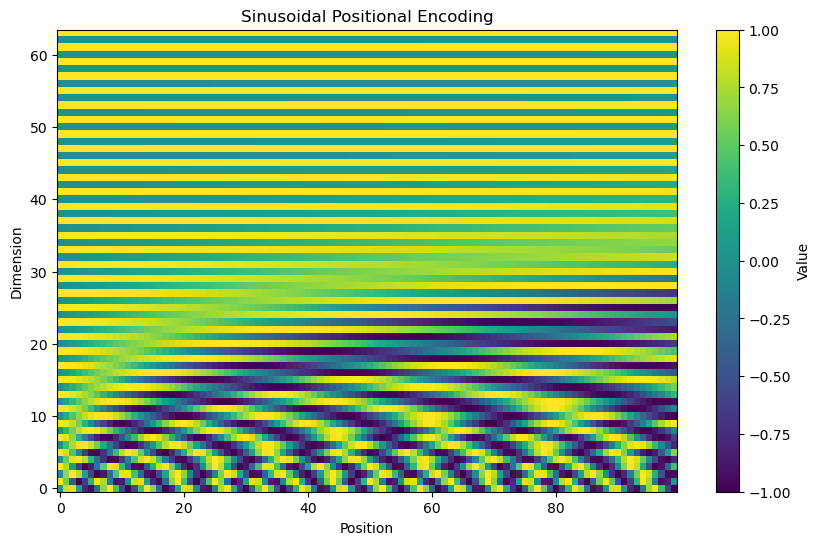

In [187]:
def positional_encoding(seq_len, dk):
    pe = torch.zeros(seq_len, dk)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    # (seq_len, 1)
    div_term = torch.exp(torch.arange(0, dk, 2).float() * (-math.log(10000.0) / dk))
    # (dk/2,)

    # position * div_term : seq_len, dk/2
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe  # (seq_len, d_model)


pe = positional_encoding(100, 64)  # T, d_K

plt.figure(figsize=(10, 6))
plt.imshow(pe.T, aspect="auto", cmap="viridis", origin="lower")
plt.xlabel("Position")
plt.ylabel("Dimension")
plt.title("Sinusoidal Positional Encoding")
plt.colorbar(label="Value")
plt.show()


# A Full Model

Stack multiple Transformer blocks and add a prediction head that maps the embeddings 
to logits over the vocabulary.

We now use some more standard design choices: 
- tokens are represented as indices (integers), we recover their embeddings by applying an embedding layer. We assume some preproprocessing was done on the data to convert  tokens into their token indices. 
- we overload the forward method:
    - when training, forward may take targets as inputs in addition to the token indices. The loss is computed inside forward and returned. 

In [ ]:
class TinyTransformer(nn.Module):
    def __init__(self, vocab_size, h, dk, n_layers, block_size, device="cpu"):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, dk)
        self.pos_emb = positional_encoding(block_size, dk)
        self.blocks = nn.Sequential(*[TransformerBlock(dk, h) for _ in range(n_layers)])
        self.ln_f = SimpleLayerNorm(dk)

        self.prediction_head = nn.Linear(dk, vocab_size)

        self.device = device
        self.vocab_size = vocab_size
        self.block_size = block_size

    def forward(self, idx, targets=None):
        B, T = idx.shape
        pos = torch.arange(T, device=self.device)
        x = self.token_emb(idx) + self.pos_emb[pos]
        x = self.blocks(x)
        logits = self.prediction_head(self.ln_f(x))
        if targets is None:
            return logits, None
        loss = F.cross_entropy(logits.view(-1, self.vocab_size), targets.view(-1))
        return logits, loss

# Next-token prediction

We are now ready to train a transformer to generate text. 

Check the input.txt file in the folder. It contains Shakespeare pieces. 

### Preprocessing:
We split the text into characters and encodes the individual characters into 
unique indices.


### Fill the get_batch function

In [190]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text = open("data/input.txt", "r").read()
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}


def encode(s):
    return torch.tensor([stoi[c] for c in s], dtype=torch.long)


def decode(t):
    return "".join([itos[int(i)] for i in t])


data = encode(text)
split = int(0.9 * len(data))
train_data, val_data = data[:split], data[split:]


def get_batch(src, batch_size, block_size, device="cpu"):
    # Picks a random batch of data from the source tensor
    # Returns input and target tensors
    ix = torch.randint(len(src) - block_size, (batch_size,))
    x = torch.stack([src[i : i + block_size] for i in ix])
    y = torch.stack([src[i + 1 : i + block_size + 1] for i in ix])
    return x.to(device), y.to(device)

In [191]:
print("Vocabulary size:", vocab_size)
print("Number of training tokens:", len(train_data))

Vocabulary size: 65
Number of training tokens: 1003854


In [192]:
h = 4
n_layers = 2
dk = 128
block_size = 128
batch_size = 32

model = TinyTransformer(vocab_size, h, dk, n_layers, block_size, device=device).to(
    device
)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n_params = count_parameters(model)
print(f"Trainable parameters: {n_params}")

Trainable parameters: 412737


In [193]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
losses = []
for step in range(2000):
    xb, yb = get_batch(train_data, batch_size, block_size)
    _, loss = model(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if step % 200 == 0:
        print(f"step {step}: loss {loss.item():.4f}")


step 0: loss 4.3574
step 200: loss 2.4875
step 400: loss 2.3430
step 600: loss 2.2260
step 800: loss 2.1621
step 1000: loss 2.0722
step 1200: loss 2.0298
step 1400: loss 1.8885
step 1600: loss 1.9251
step 1800: loss 1.8713


KeyboardInterrupt: 

# Generate some text

In [194]:
def generate(model, idx, max_new_tokens):
    # Generate new tokens given a context idx
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -model.block_size :]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)
    return idx

In [196]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(generate(model, context, max_new_tokens=500)[0].tolist()))


FRIRD:
That the poos-trowans, I will heared.

CARTILLLANE:
Go, sterx'd my then;
But 'noble, in 'ppor how with dopers quaree,
So Istalter knep's to prody fror theys,
Natter in be dun deneors yourse the you chaste;
Who, me sucon forg of youghtines not
Nurdeedian'd is this the likng your in ippove
For have apperitse your mukese for me.


LAUTERY's:
Whit wered harlis! 'me again another,
Kiving is mukne brog acck to a tend with on trebly,
I lot no t ra nonie berty; lovesser; melon.

CLINCENCENY:
I me
